In [ ]:
# Cell 1: Imports + Load Data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

sns.set_theme(style="whitegrid")
np.random.seed(42)

# I load the training data from here (make path robust)
BASE = Path.cwd()
DATA_PATH = BASE / "data" / "Data_Train.csv"
if not DATA_PATH.exists():
    # if the notebook runs from notebooks/ folder, go one level up
    BASE = BASE.parent
    DATA_PATH = BASE / "data" / "Data_Train.csv"

print("Using data file:", DATA_PATH)
df = pd.read_csv(DATA_PATH)
print(f"Dataset shape: {df.shape}")
display(df.head())

# Heads-up from me: the real price column is `Price`.
# There is no `days_left`, so I simulate it later (1-30) to fit the airline story.


Dataset shape: (10683, 11)


,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
0,IndiGo,24/03/2019,Banglore,New Delhi,BLR ? DEL,22:20,01:10 22 Mar,2h 50m,non-stop,No info,3897
1,Air India,1/05/2019,Kolkata,Banglore,CCU ? IXR ? BBI ? BLR,05:50,13:15,7h 25m,2 stops,No info,7662
2,Jet Airways,9/06/2019,Delhi,Cochin,DEL ? LKO ? BOM ? COK,09:25,04:25 10 Jun,19h,2 stops,No info,13882
3,IndiGo,12/05/2019,Kolkata,Banglore,CCU ? NAG ? BLR,18:05,23:30,5h 25m,1 stop,No info,6218
4,IndiGo,01/03/2019,Banglore,New Delhi,BLR ? NAG ? DEL,16:50,21:35,4h 45m,1 stop,No info,13302


              price     days_left
count  10683.000000  10683.000000
mean    9087.064121     15.707292
std     4611.359167      8.662944
min     1759.000000      1.000000
25%     5277.000000      8.000000
50%     8372.000000     16.000000
75%    12373.000000     23.000000
max    79512.000000     30.000000


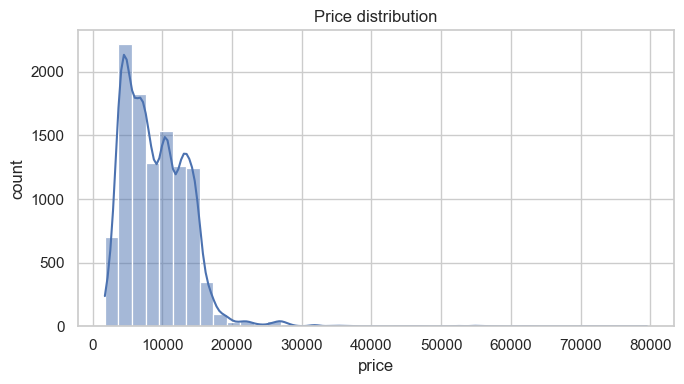

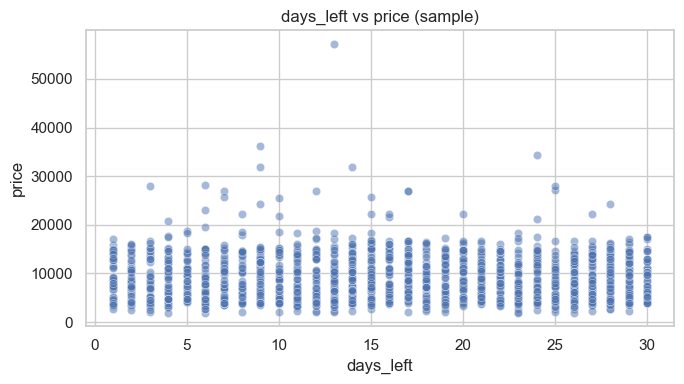

In [ ]:
# Cell 2: Quick EDA (plots)

# I keep a consistent set of columns for the rest of the notebook
# - `price` is my continuous target
# - `days_left` is simulated (I add it so the story makes sense)
df = df.copy()
df["price"] = df["Price"].astype(float)
df["days_left"] = np.random.randint(1, 31, size=len(df))

print(df[["price", "days_left"]].describe())

plt.figure(figsize=(7, 4))
sns.histplot(df["price"], bins=40, kde=True)
plt.title("Price distribution")
plt.xlabel("price")
plt.ylabel("count")
plt.tight_layout()
plt.show()

plt.figure(figsize=(7, 4))
sns.scatterplot(data=df.sample(min(1500, len(df)), random_state=42), x="days_left", y="price", alpha=0.5)
plt.title("days_left vs price (sample)")
plt.xlabel("days_left")
plt.ylabel("price")
plt.tight_layout()
plt.show()


In [ ]:
# Cell 3: Feature Engineering
from sklearn.preprocessing import LabelEncoder


def _parse_duration_minutes(s: str) -> float:
    if pd.isna(s):
        return np.nan
    s = str(s).lower().strip()
    h = 0
    m = 0
    if "h" in s:
        try:
            h = int(s.split("h")[0].strip())
        except Exception:
            h = 0
    if "m" in s:
        try:
            m = int(s.split("h")[-1].replace("m", "").strip())
        except Exception:
            m = 0
    total = h * 60 + m
    return float(total) if total > 0 else np.nan


def _parse_stops(s: str) -> float:
    if pd.isna(s):
        return np.nan
    s = str(s).lower().strip()
    if s == "non-stop":
        return 0.0
    try:
        return float(int(s.split()[0]))
    except Exception:
        return np.nan


def feature_engineering(data: pd.DataFrame) -> pd.DataFrame:
    data = data.copy()

    # I simulate how many times the user visited (1-5)
    data["user_visit_count"] = np.random.randint(1, 6, size=len(data))

    # I build an urgency score: fewer days + more visits => more urgency (cap days_left at 5)
    data["urgency_score"] = (6 - data["days_left"].clip(upper=5)) * data["user_visit_count"]

    # Occupancy is not in the dataset, so I simulate it (0.50 - 0.99)
    data["occupancy"] = np.random.uniform(0.50, 0.99, size=len(data)).round(3)

    # Extra numeric features from date/time/duration/stops
    if "Date_of_Journey" in data.columns:
        dt = pd.to_datetime(data["Date_of_Journey"], format="%d/%m/%Y", errors="coerce")
        data["journey_month"] = dt.dt.month
        data["journey_day"] = dt.dt.day
        data["journey_dow"] = dt.dt.dayofweek

    if "Dep_Time" in data.columns:
        hh = pd.to_numeric(data["Dep_Time"].astype(str).str.split(":").str[0], errors="coerce")
        mm = pd.to_numeric(data["Dep_Time"].astype(str).str.split(":").str[1], errors="coerce")
        data["dep_hour"] = hh
        data["dep_minute"] = mm

    if "Duration" in data.columns:
        data["duration_min"] = data["Duration"].apply(_parse_duration_minutes)

    if "Total_Stops" in data.columns:
        data["stops_n"] = data["Total_Stops"].apply(_parse_stops)

    # I make categoricals numeric (Label Encoding)
    cat_cols = [c for c in data.columns if data[c].dtype == "object"]
    for c in cat_cols:
        le = LabelEncoder()
        # Convert NaNs to string so LabelEncoder doesn't crash
        data[c] = le.fit_transform(data[c].astype(str))

    return data


df_fe = feature_engineering(df)
print(
    "New columns:",
    [c for c in ["user_visit_count", "urgency_score", "occupancy"] if c in df_fe.columns],
)
display(df_fe.head())


New columns: ['user_visit_count', 'urgency_score', 'occupancy']


,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,...,user_visit_count,urgency_score,occupancy,journey_month,journey_day,journey_dow,dep_hour,dep_minute,duration_min,stops_n
0,3,24,0,5,18,211,233,240,5,8,...,5,5,0.548,3,24,6,22,20,170.0,0.0
1,1,6,3,0,84,31,906,336,1,8,...,1,1,0.919,5,1,2,5,50,445.0,2.0
2,4,43,2,1,118,70,413,106,1,8,...,2,2,0.735,6,9,6,9,25,1140.0,2.0
3,3,10,3,0,91,164,1324,311,0,8,...,3,3,0.905,5,12,6,18,5,325.0,1.0
4,3,0,0,5,29,149,1237,303,0,8,...,4,4,0.900,3,1,4,16,50,285.0,1.0


In [4]:
# Cell 4: Target + Train/Test Split
from sklearn.model_selection import train_test_split

# Turn price into 3 classes: 0=Cheap, 1=Mid, 2=Expensive
# We use qcut so each class has roughly the same amount of samples.
df_fe = df_fe.copy()
df_fe["price_category"] = pd.qcut(df_fe["price"], q=3, labels=[0, 1, 2])

# Save thresholds (nice to mention in the report)
q33 = float(df_fe["price"].quantile(1 / 3))
q66 = float(df_fe["price"].quantile(2 / 3))
print(f"Cheap (0): price <= {q33:.2f}")
print(f"Mid   (1): {q33:.2f} < price <= {q66:.2f}")
print(f"Expensive (2): price > {q66:.2f}")

# X / y
X = df_fe.drop(["Price", "price", "price_category"], axis=1, errors="ignore")
y = df_fe["price_category"].astype(int)

# Data leakage check: price must NOT be inside X
assert "price" not in X.columns and "Price" not in X.columns

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y,
)

print("X_train:", X_train.shape, "X_test:", X_test.shape)
print("Class distribution (train):")
print(y_train.value_counts().sort_index())


Cheap (0): price <= 6368.00
Mid   (1): 6368.00 < price <= 10844.00
Expensive (2): price > 10844.00
X_train: (8546, 21) X_test: (2137, 21)
Class distribution (train):
price_category
0    2849
1    2915
2    2782
Name: count, dtype: int64


In [ ]:
# Cell 5: Missing values (quick fix)
# I fill NaNs with median values so SMOTE/models won't crash.

from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy="median")

X_train = pd.DataFrame(
    imputer.fit_transform(X_train),
    columns=X_train.columns,
    index=X_train.index,
)
X_test = pd.DataFrame(
    imputer.transform(X_test),
    columns=X_test.columns,
    index=X_test.index,
)

print("NaN count (train) after imputation:", int(np.isnan(X_train.to_numpy()).sum()))
print("NaN count (test)  after imputation:", int(np.isnan(X_test.to_numpy()).sum()))


NaN count (train) after imputation: 0
NaN count (test)  after imputation: 0


In [ ]:
# Cell 6: Sampling Strategy (SMOTE)
from imblearn.over_sampling import SMOTE

# I balance the training set by oversampling minority classes
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

# SMOTE may return numpy arrays; I convert back to pandas for readability
X_train_res = pd.DataFrame(X_train_res, columns=X_train.columns)
y_train_res = pd.Series(y_train_res)

print("Before:")
print(y_train.value_counts().sort_index())
print("\nAfter (SMOTE):")
print(y_train_res.value_counts().sort_index())


Before:
price_category
0    2849
1    2915
2    2782
Name: count, dtype: int64

After (SMOTE):
price_category
0    2915
1    2915
2    2915
Name: count, dtype: int64


In [ ]:
# Cell 7: Train models (DT / RF / optional XGBoost)
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

# I try XGBoost; if it fails I continue with DT + RF.
try:
    from xgboost import XGBClassifier
    has_xgb = True
except Exception as e:
    has_xgb = False
    print("XGBoost import failed, I continue with DT + RF:", repr(e))

models = {
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1),
}

if has_xgb:
    models["XGBoost"] = XGBClassifier(
        random_state=42,
        n_estimators=250,
        max_depth=6,
        learning_rate=0.08,
        subsample=0.9,
        colsample_bytree=0.9,
        objective="multi:softprob",
        num_class=3,
        eval_metric="mlogloss",
        tree_method="hist",
    )

for name, model in models.items():
    model.fit(X_train_res, y_train_res)
    print(f"Trained: {name}")


Trained: Decision Tree
Trained: Random Forest
Trained: XGBoost


In [ ]:
# Cell 8: Results + McNemar test
from sklearn.metrics import classification_report, accuracy_score
from statsmodels.stats.contingency_tables import mcnemar

# I print quick metrics per model
for name, model in models.items():
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print(f"\n=== {name} ===")
    print(f"Accuracy: {acc:.4f}")
    print(classification_report(y_test, y_pred, digits=4, zero_division=0))

# I compare XGBoost vs Random Forest with McNemar (only if both exist)
if ("XGBoost" in models) and ("Random Forest" in models):
    y_pred_xgb = models["XGBoost"].predict(X_test)
    y_pred_rf = models["Random Forest"].predict(X_test)

    # 2x2 table of correct/incorrect
    correct_xgb = (y_pred_xgb == y_test.to_numpy())
    correct_rf = (y_pred_rf == y_test.to_numpy())

    n00 = int(np.sum(~correct_xgb & ~correct_rf))  # both wrong
    n01 = int(np.sum(~correct_xgb &  correct_rf))  # xgb wrong, rf right
    n10 = int(np.sum( correct_xgb & ~correct_rf))  # xgb right, rf wrong
    n11 = int(np.sum( correct_xgb &  correct_rf))  # both right

    table = [[n00, n01], [n10, n11]]
    res = mcnemar(table, exact=False, correction=True)

    print("\nMcNemar 2x2 table (rows=XGB correct?, cols=RF correct?):")
    print({"n00": n00, "n01": n01, "n10": n10, "n11": n11})
    print(f"McNemar statistic={res.statistic:.4f}, p-value={res.pvalue:.6f}")

    alpha = 0.05
    if res.pvalue < alpha:
        print(
            f"My read: p<{alpha}, so XGBoost vs RF difference is statistically significant."
        )
    else:
        print(
            f"My read: p>={alpha}, so the difference is NOT statistically significant (could be luck)."
        )
else:
    print("\nMcNemar: XGBoost or Random Forest missing (maybe xgboost import failed).")



=== Decision Tree ===
Accuracy: 0.8844
              precision    recall  f1-score   support

           0     0.9101    0.9242    0.9171       712
           1     0.8397    0.8409    0.8403       729
           2     0.9050    0.8894    0.8971       696

    accuracy                         0.8844      2137
   macro avg     0.8849    0.8848    0.8848      2137
weighted avg     0.8844    0.8844    0.8844      2137


=== Random Forest ===
Accuracy: 0.9069
              precision    recall  f1-score   support

           0     0.9282    0.9256    0.9269       712
           1     0.8612    0.8765    0.8688       729
           2     0.9343    0.9195    0.9269       696

    accuracy                         0.9069      2137
   macro avg     0.9079    0.9072    0.9075      2137
weighted avg     0.9073    0.9069    0.9071      2137


=== XGBoost ===
Accuracy: 0.9111
              precision    recall  f1-score   support

           0     0.9340    0.9340    0.9340       712
           1   

,Scenario,BasePrice,DynamicPrice,Delta
0,"2 days left, 4th visit, 90% occupancy",8372.0,11714.1,3342.1
1,"15 days left, 1st visit, 55% occupancy",8372.0,8372.0,0.0


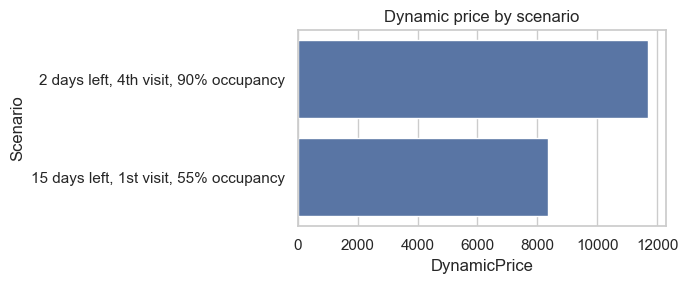

In [ ]:
# Cell 9: Dynamic pricing demo (simple if-else)

def dynamic_price(base_price: float, days_left: int, user_visit_count: int, occupancy: float) -> float:
    factor = 1.0

    # If there are fewer days left, I increase the price
    if days_left <= 2:
        factor *= 1.20
    elif days_left <= 7:
        factor *= 1.08

    # If the user visits a lot, I nudge the price up a bit
    if user_visit_count >= 4:
        factor *= 1.06
    elif user_visit_count >= 2:
        factor *= 1.03

    # If occupancy is high, I increase price
    if occupancy >= 0.95:
        factor *= 1.18
    elif occupancy >= 0.85:
        factor *= 1.10

    return round(base_price * factor, 2)


# I show two scenarios with the same base price
base = float(df_fe["price"].median())

scenarios = [
    {"scenario": "2 days left, 4th visit, 90% occupancy", "days_left": 2, "user_visit_count": 4, "occupancy": 0.90},
    {"scenario": "15 days left, 1st visit, 55% occupancy", "days_left": 15, "user_visit_count": 1, "occupancy": 0.55},
]

rows = []
for s in scenarios:
    p = dynamic_price(base, s["days_left"], s["user_visit_count"], s["occupancy"])
    rows.append({
        "Scenario": s["scenario"],
        "BasePrice": base,
        "DynamicPrice": p,
        "Delta": p - base,
    })

out = pd.DataFrame(rows)
display(out)

plt.figure(figsize=(7, 3))
sns.barplot(data=out, x="DynamicPrice", y="Scenario", orient="h")
plt.title("Dynamic price by scenario")
plt.tight_layout()
plt.show()


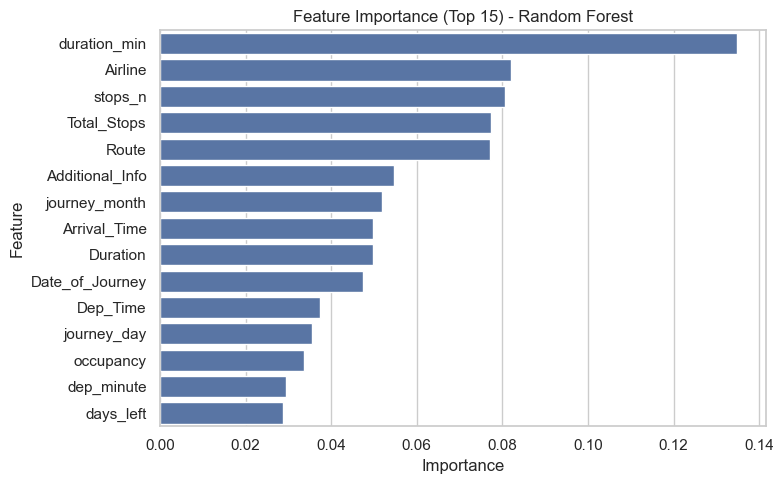

,feature,importance
19,duration_min,0.134855
0,Airline,0.082002
20,stops_n,0.080497
8,Total_Stops,0.077287
4,Route,0.077154
9,Additional_Info,0.054793
14,journey_month,0.051910
6,Arrival_Time,0.049844
7,Duration,0.049736
1,Date_of_Journey,0.047344


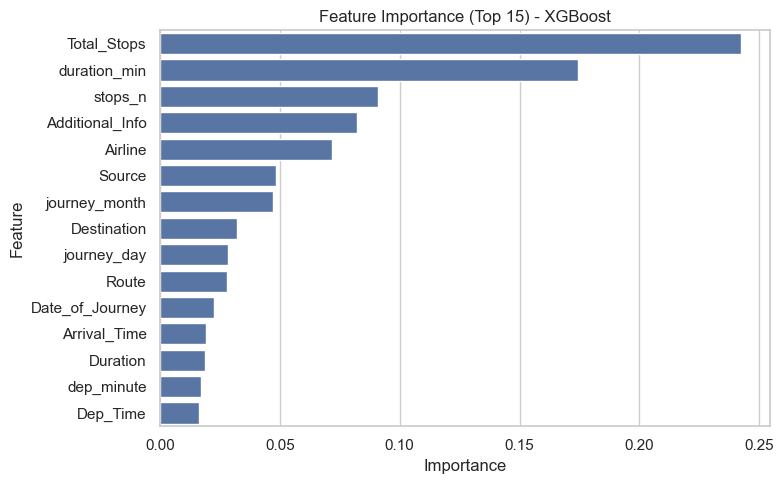

,feature,importance
8,Total_Stops,0.242350
19,duration_min,0.174559
20,stops_n,0.091056
9,Additional_Info,0.082411
0,Airline,0.071764
2,Source,0.048320
14,journey_month,0.047368
3,Destination,0.032061
15,journey_day,0.028559
4,Route,0.027958


In [ ]:
# Extra 1: Feature Importance (RF / XGBoost)

feature_names = list(X_train.columns)

if "Random Forest" in models and hasattr(models["Random Forest"], "feature_importances_"):
    importances = models["Random Forest"].feature_importances_
    imp_df = pd.DataFrame({"feature": feature_names, "importance": importances}).sort_values(
        "importance", ascending=False
    )

    topk = 15
    plt.figure(figsize=(8, 5))
    sns.barplot(data=imp_df.head(topk), x="importance", y="feature", orient="h")
    plt.title(f"Feature Importance (Top {topk}) - Random Forest")
    plt.xlabel("Importance")
    plt.ylabel("Feature")
    plt.tight_layout()
    plt.show()

    display(imp_df.head(topk))
else:
    print("RF: no feature_importances_ attribute.")

if "XGBoost" in models and hasattr(models["XGBoost"], "feature_importances_"):
    xgb_imp = models["XGBoost"].feature_importances_
    xgb_df = pd.DataFrame({"feature": feature_names, "importance": xgb_imp}).sort_values(
        "importance", ascending=False
    )

    topk = 15
    plt.figure(figsize=(8, 5))
    sns.barplot(data=xgb_df.head(topk), x="importance", y="feature", orient="h")
    plt.title(f"Feature Importance (Top {topk}) - XGBoost")
    plt.xlabel("Importance")
    plt.ylabel("Feature")
    plt.tight_layout()
    plt.show()

    display(xgb_df.head(topk))


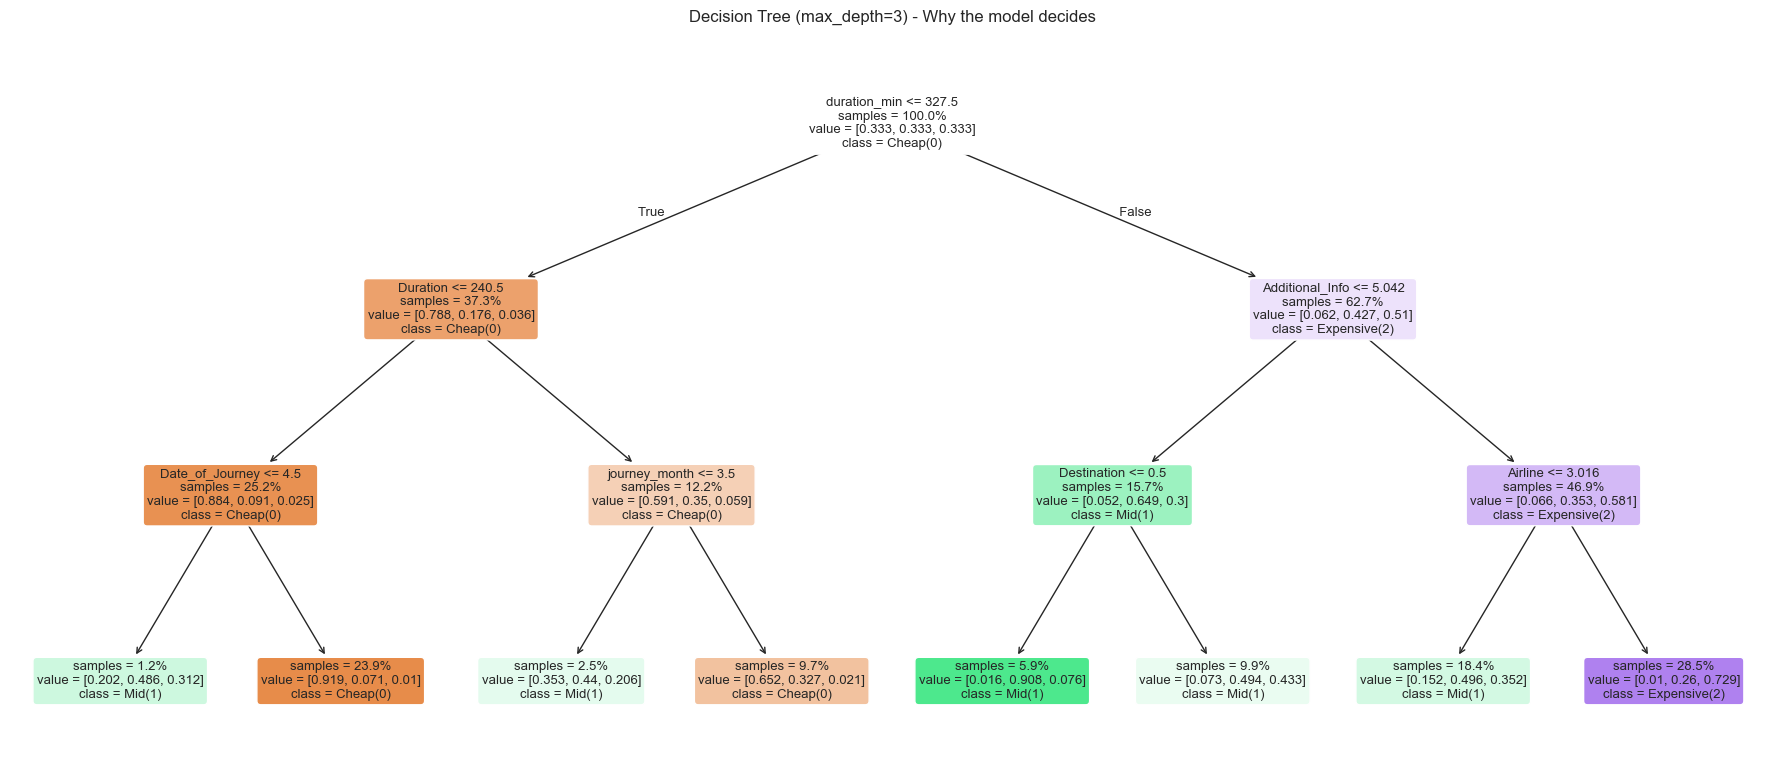

In [ ]:
# Extra 2: Explainability - Small Decision Tree plot
from sklearn.tree import plot_tree

# I train a shallow tree just to visualize the decision logic
viz_tree = DecisionTreeClassifier(random_state=42, max_depth=3, min_samples_leaf=50)
viz_tree.fit(X_train_res, y_train_res)

plt.figure(figsize=(18, 8))
plot_tree(
    viz_tree,
    feature_names=feature_names,
    class_names=["Cheap(0)", "Mid(1)", "Expensive(2)"],
    filled=True,
    rounded=True,
    impurity=False,
    proportion=True,
    max_depth=3,
)
plt.title("Decision Tree (max_depth=3) - How I see the splits")
plt.tight_layout()
plt.show()


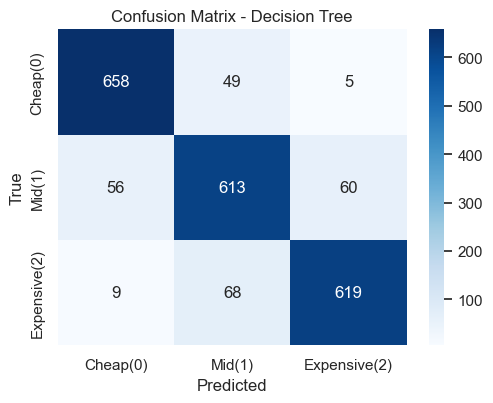


Decision Tree note: The model confused 9 'Expensive' tickets as 'Cheap'; this can hurt profit. Also 5 'Cheap' tickets were predicted as 'Expensive'; that could hurt customer happiness.


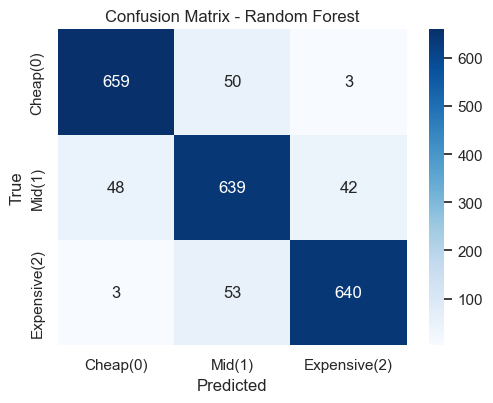


Random Forest note: The model confused 3 'Expensive' tickets as 'Cheap'; this can hurt profit. Also 3 'Cheap' tickets were predicted as 'Expensive'; that could hurt customer happiness.


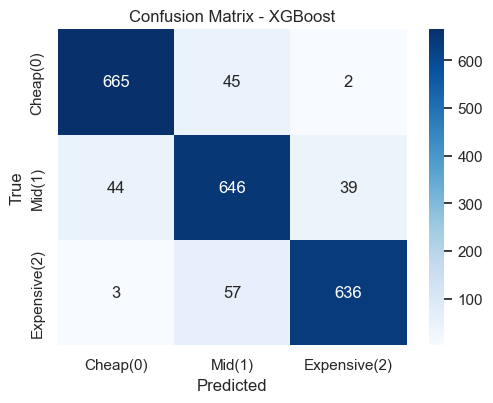


XGBoost note: The model confused 3 'Expensive' tickets as 'Cheap'; this can hurt profit. Also 2 'Cheap' tickets were predicted as 'Expensive'; that could hurt customer happiness.


In [ ]:
# Extra 3: Confusion Matrix + one-line note
from sklearn.metrics import confusion_matrix

labels = [0, 1, 2]
label_names = ["Cheap(0)", "Mid(1)", "Expensive(2)"]

for name, model in models.items():
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred, labels=labels)

    plt.figure(figsize=(5.2, 4.2))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_names, yticklabels=label_names)
    plt.title(f"Confusion Matrix - {name}")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.show()

    # For me, expensive→cheap is the worst case (profit loss)
    expensive_as_cheap = int(cm[2, 0])
    cheap_as_expensive = int(cm[0, 2])

    if expensive_as_cheap == 0:
        msg = "I don't confuse 'Expensive' with 'Cheap' here, so profit is protected." 
    else:
        msg = (
            f"I confused {expensive_as_cheap} 'Expensive' tickets as 'Cheap'; this can hurt profit."
        )

    if cheap_as_expensive > 0:
        msg += f" Also {cheap_as_expensive} 'Cheap' tickets were predicted as 'Expensive'; that can annoy customers."

    print(f"\n{name} note: {msg}")
